# This notebooks makes simulations of swell propagation on the sphere using analytical forms for 
# wave spectrum in storm. This is the isotropic version.
### F. Ardhuin, 2009, adapted to python and updated 2025

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import minimize

from datetime import datetime, timedelta
import glob as glob 
import cartopy.crs       as ccrs
import sys


##Functions git swellSWOT
sys.path.append('/home/ardhuin/TOOLS/swellSWOT/src/')
import swot_swell_utils as swell
import swot_ssh_utils as swot
from  spectral_analysis_functions import *
import pickle


#Colormaps 
import cmocean
import cmocean.cm as cmo
topocmap = cmocean.tools.lighten(cmo.topo, 1)
dircmap = cmocean.tools.lighten(cmo.phase, 1)
lightcmap = cmocean.tools.lighten(cmo.ice, 1)


# %matplotlib ipympl #Permet zoom dans figures
r2d = 180/np.pi;
g=9.81;
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})
mpl.rcParams.update({'figure.figsize':[14,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})


Hs for JONSWAP and updated spectrum : 19.981571077130436 18.403277880297356


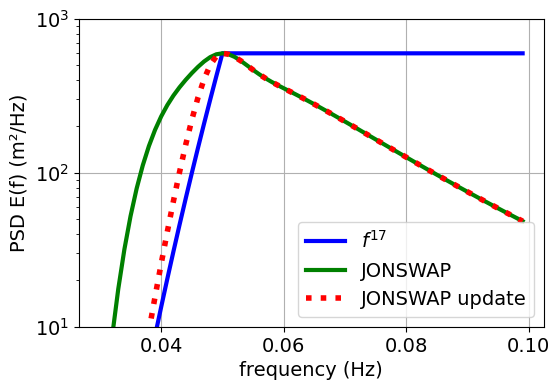

In [4]:
# Some basic plots of JONSWAP spectrum and updated JONSWAP spectrum
gammaPM=1.3
f0=0.05

#sigf=0.01;
#Ef0=exp(-((f-f0)./sigf).^2);

df=0.001
f=np.arange(0.03,0.1,df)

pow=17;tac=5;alphaPM=0.0081*9.81**2/(2*np.pi)**4
facPM=np.where(f > f0,np.exp(-1.25*(f/f0)**-4),np.exp(-1.25)*(f/f0)**(5+pow*np.tanh(tac*(f0-f)/f0)))

EfJ=alphaPM*f**-5*np.exp(-1.25*(f/f0)**-4)*gammaPM**(np.exp(-(f-f0)**2/(2*(0.07*f0)**2)))

EfJU=alphaPM*f**-5*facPM*gammaPM**(np.exp(-(f-f0)**2/(2*(0.07*f0)**2)))
Efm=np.max(EfJ)
Ef17=(f/f0)**17
Ef17=np.where(Ef17 > 1,1,Ef17)*Efm

Hs0=4*np.sqrt(np.sum(EfJ)*df*np.pi/2)
Hs1=4*np.sqrt(np.sum(EfJU)*df*np.pi/2)
print('Hs for JONSWAP and updated spectrum :',Hs0,Hs1)

fig,axs=plt.subplots(1,1,figsize=(6,4))
axs.plot(f,Ef17,c='b',alpha=1,linewidth=3,label=r'$f^{17}$');
axs.semilogy(f,EfJ,c='g',alpha=1,linewidth=3,label='JONSWAP');
axs.plot(f,EfJU,c='r',alpha=1,linewidth=4, linestyle=':',label='JONSWAP update');
axs.set_ylim(10,1000)
axs.set_ylabel('PSD E(f) (m²/Hz)')
axs.set_xlabel('frequency (Hz)')
axs.legend(loc='lower right')
fig.savefig('JONSWAP_update_gamma1p3_log.pdf')

In [11]:
# Functions for spectral shapes
def EfJ_func(f,f0=0.05,gammaPM=2):
    pow=17;tac=5;alphaPM=0.0081*9.81**2/(2*np.pi)**4
    facPM=np.where(f > f0,np.exp(-1.25*(f/f0)**-4),np.exp(-1.25)*(f/f0)**(5+pow*np.tanh(tac*(f0-f)/f0)))
    # Usual JONSWAP spectrum (this one with siga=sigb=0.07)
    EfJ=alphaPM*f**-5*np.exp(-1.25*(f/f0)**-4)*gammaPM**(np.exp(-(f-f0)**2/(2*(0.07*f0)**2)))
    # update on JONSWAP form 
    EfJU=alphaPM*f**-5*facPM*gammaPM**(np.exp(-(f-f0)**2/(2*(0.07*f0)**2)))         
    return EfJ, EfJU


# propagation of isotropic spectra uniform over radius r 
def propagate_waves_iso(X,t,r,center,f0,gammaPM,epsf=0.0):
#r=400;                     # radius of source area in km. Source is centered at south pole
  tpi=2*np.pi
  nth=50
  nx=len(X)
  Es=np.zeros(nx);
  EsJ=np.zeros(nx);
  Esm1=np.zeros(nx);
  EsJm1=np.zeros(nx);    

  R=40000/(2*np.pi)          # Earth radius
  uorb=2                     # some average value of orbital velocity in m/s
  phi=r/R                    #
  dx0=5;
  x0=np.arange(-r,r,dx0)
  nx2=len(x0)

# first loop on observation points
  for i in range(nx):
    #for dk=0:0 #-1:1 %1:NX
    di=0  # possible shift 
    i2=np.min([np.max([i-2*di,0]),nx]) 
    #XX(i,k)=X(k)
    D=X[i]
    al=(X[i]+center)/R
    alpmin=al-r/R;
    alpmax=al+r/R;
    # second loop to discretize storm
    dthm=0
    nthm=0
    for j in range(nx2):
        alpR=X[i2]-x0[j];
        alp=alpR/R;
        # fj is the wave frequency corresponding to distance alpR
        fj=g*t/((4*np.pi)*alpR*1000)  # 1000 converts km to m 
        # includes dissipation 
        mu=uorb*epsf*1.2E-3*64*(np.pi)**3/(9.81**2/fj**3)*1000  # eq. 6 in Ardhuin et al. 2009 in km-1
        
        cost=(np.cos(phi)-np.cos(al)*np.cos(alp))/(np.sin(al)*np.sin(alp))
        if (abs(cost) < 1):
            dtheta=2*np.arccos(cost);
            
            EfJ,EfJU=EfJ_func(fj,f0,gammaPM)
            diss=np.exp(-mu*(D-x0[j]))
            # directional spectral density for istropic spectrum is E(f)/tpi
            Es[i]=Es[i]      +fj*EfJU/tpi/(D-x0[j])*dx0*dtheta*diss
            EsJ[i]=EsJ[i]    +fj*EfJ/tpi /(D-x0[j])*dx0*dtheta*diss
            Esm1[i]=Esm1[i]  +fj*EfJU/tpi/(D-x0[j])*dx0*dtheta*diss/fj
            EsJm1[i]=EsJm1[i]+fj*EfJ/tpi /(D-x0[j])*dx0*dtheta*diss/fj
            dthm=dthm+dtheta
            nthm=nthm+1
    #print('dt:',i,al*R,nthm,dthm, np.pi*r/R/(2*np.sin(alp)),np.pi*r/R/(2*np.sin(alp))*nthm)  # this is to check the simplified formula 
  return Es, EsJ, Esm1, EsJm1  

    

dx=100                     # spatial resoltion for computing the observed wave energy 
X=np.arange(dx,15000,dx)   # positions for observed spectra

tds=86400*7 # X(i2)/(g/(4*pi*f1))  # propagation time days*86400 to give seconds
epsf=0.000
# only one uniform area
Es1, EsJ1, Esm11, EsJm11 = propagate_waves_iso(X,tds,500,center=0,f0=0.05,gammaPM=2,epsf=epsf)
Es2, EsJ2, Esm12, EsJm12 = [0,0,0,0]
Es3, EsJ3, Esm13, EsJm13 = [0,0,0,0]

# another uniform area
#Es3, EsJ3, Esm13, EsJm13  =propagate_waves_iso(X,tds,1000,center=300,f0=0.065,gammaPM=2,epsf=epsf)
#removes energy if the second area surrounds the first
#Es2, EsJ2, Esm12, EsJm12 = propagate_waves_iso(X,tds,300,center=0,f0=0.065,gammaPM=2,epsf=epsf)

Es=Es1-Es2+Es3
EsJ=EsJ1-EsJ2+EsJ3
Esm1=Esm11-Esm12+Esm13
EsJm1=EsJm11-EsJm12+EsJm13

/tmp/ipykernel_556092/3832126062.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  fj=g*t/((4*np.pi)*alpR*1000)  # 1000 converts km to m
/tmp/ipykernel_556092/3832126062.py:49: RuntimeWarning: invalid value encountered in scalar divide
  mu=uorb*epsf*1.2E-3*64*(np.pi)**3/(9.81**2/fj**3)*1000  # eq. 6 in Ardhuin et al. 2009 in km-1
/tmp/ipykernel_556092/3832126062.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  cost=(np.cos(phi)-np.cos(al)*np.cos(alp))/(np.sin(al)*np.sin(alp))


Tp,R (km): 19.95424028525203 499.59655822165666 Toba H: 17.30927945561445 r*factor: 0.0009936115944188864


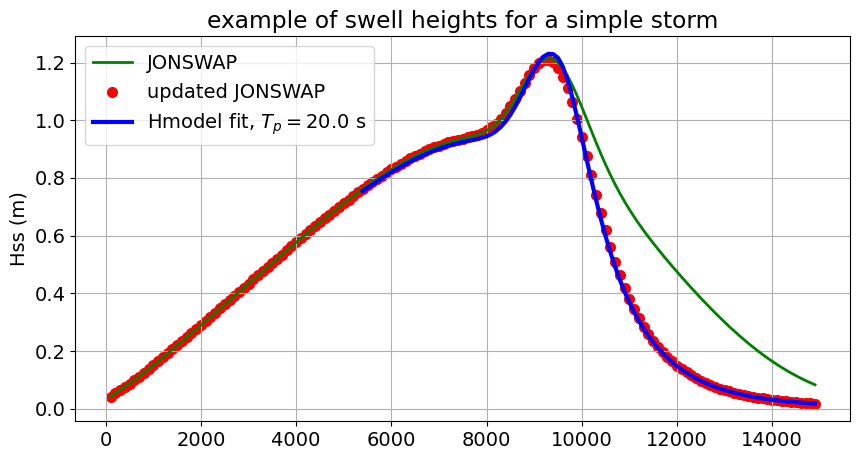

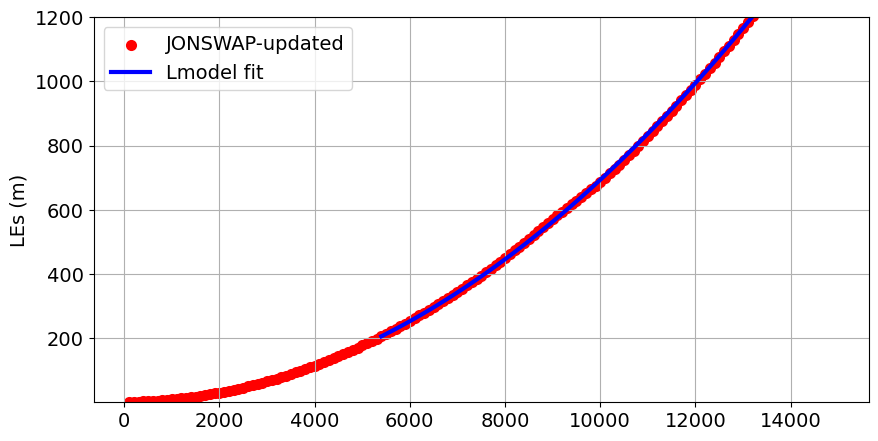

In [13]:
# fitting Hmodel as used for data ... 
R=40000/(2*np.pi)          # Earth radius

Hss=4*np.sqrt(Es)
TEs=Esm1/Es
LEs=TEs**2*9.81/(2*np.pi)

a0=(X)/R  # alpha

incognita=[0,0]
inds=np.where(LEs > 200)[0]

xopt = minimize(eval('swell.Lmodel'), incognita, args=((LEs[inds],a0[inds],'LS',tds),),\
                     method='Nelder-Mead',options={'disp': False}) 
# First we adjust the distance / time 
ashift=xopt.x[0];tshift=xopt.x[1]
fj,Lj=swell.Lmodel_eval(a0,tds,[ashift,tshift])
alp=a0+ashift

f0=0.0532;
costpow=0
gammaPM=2
r=100E3

alphaP=0.0081*9.81**2/(2*np.pi)**4
factor=4*np.sqrt(alphaP/2)/R


incognita=[0.06,2E-3,gammaPM]
xopt = minimize(eval('swell.Hmodel'), incognita, args=((Hss[inds],a0[inds],fj[inds],gammaPM,costpow,'LS'),),\
      method='Nelder-Mead',options={'disp': False})
f0=xopt.x[0]
radius=xopt.x[1]/factor

Tp=1/f0
print('Tp,R (km):',Tp,radius,'Toba H:',0.062*np.sqrt(9.81*1*Tp**3),'r*factor:',r*factor*1E-3)

HJ8=swell.Hmodel_eval(alp,fj,gammaPM,[f0,xopt.x[1],gammaPM])
#HJ8=swell.Hmodel_eval(alp,fj,gammaPM,[0.05,300000,gammaPM])

fig,axs=plt.subplots(1,1,figsize=(10,5))
axs.plot(X,4*np.sqrt(EsJ),c='g',alpha=1,linewidth=2,label='JONSWAP');
axs.scatter(X,Hss,c='r',alpha=1,linewidth=2,label='updated JONSWAP');
axs.plot(X[inds],HJ8[inds],c='b',alpha=1,linewidth=3,label='Hmodel fit, $T_p=$'+f'{1/f0:03.1f}'+' s');
#axs.plot(X,400*a0**-9,c='k',alpha=0.5,linewidth=1,label='power law');
axs.legend(loc='upper left', fontsize=14)
#axs.set_ylim(1E-2,3.5)
axs.set_ylabel('Hss (m)')
axs.set_title('example of swell heights for a simple storm')
fig.savefig('dispersion_model_example_restricted_fit.pdf')

fig,axs=plt.subplots(1,1,figsize=(10,5))
axs.scatter(X,LEs,c='r',alpha=1,linewidth=2,label='JONSWAP-updated');
axs.plot(X[inds],Lj[inds],c='b',alpha=1,linewidth=3,label='Lmodel fit');
#axs.plot(X,EsJm1/EsJ,c='black',alpha=1,linewidth=2,label='JONSWAP');
#axs.plot(X,15*a0,c='g',alpha=0.5,linewidth=1,label='power law');
axs.set_ylim(1E-2,1200)
axs.set_ylabel('LEs (m)')
axs.legend(loc='upper left', fontsize=14)



In [14]:

dx=100                     # spatial resoltion for computing the observed wave energy 
X=np.arange(dx,15000,dx)   # positions for observed spectra

tds=86400*7 # X(i2)/(g/(4*pi*f1))  # propagation time days*86400 to give seconds
epsf=0.000
# only one uniform area
Es1, EsJ1, Esm11, EsJm11 = propagate_waves_iso(X,tds,500,center=0,f0=0.05,gammaPM=2,epsf=epsf)
Es2, EsJ2, Esm12, EsJm12 = [0,0,0,0]
Es3, EsJ3, Esm13, EsJm13 = [0,0,0,0]

# another uniform area
Es3, EsJ3, Esm13, EsJm13  =propagate_waves_iso(X,tds,1000,center=300,f0=0.065,gammaPM=2,epsf=epsf)
#removes energy if the second area surrounds the first
Es2, EsJ2, Esm12, EsJm12 = propagate_waves_iso(X,tds,300,center=0,f0=0.065,gammaPM=2,epsf=epsf)

Es=Es1-Es2+Es3
EsJ=EsJ1-EsJ2+EsJ3
Esm1=Esm11-Esm12+Esm13
EsJm1=EsJm11-EsJm12+EsJm13

/tmp/ipykernel_556092/3832126062.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  fj=g*t/((4*np.pi)*alpR*1000)  # 1000 converts km to m
/tmp/ipykernel_556092/3832126062.py:49: RuntimeWarning: invalid value encountered in scalar divide
  mu=uorb*epsf*1.2E-3*64*(np.pi)**3/(9.81**2/fj**3)*1000  # eq. 6 in Ardhuin et al. 2009 in km-1
/tmp/ipykernel_556092/3832126062.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  cost=(np.cos(phi)-np.cos(al)*np.cos(alp))/(np.sin(al)*np.sin(alp))
/tmp/ipykernel_556092/3832126062.py:51: RuntimeWarning: invalid value encountered in scalar divide
  cost=(np.cos(phi)-np.cos(al)*np.cos(alp))/(np.sin(al)*np.sin(alp))


Tp,R (km): 19.09057670847942 739.9978196276609 Toba H: 16.1977527542181 r*factor: 0.0009936115944188864


/tmp/ipykernel_556092/3615250597.py:4: RuntimeWarning: invalid value encountered in sqrt
  Hss=4*np.sqrt(Es)


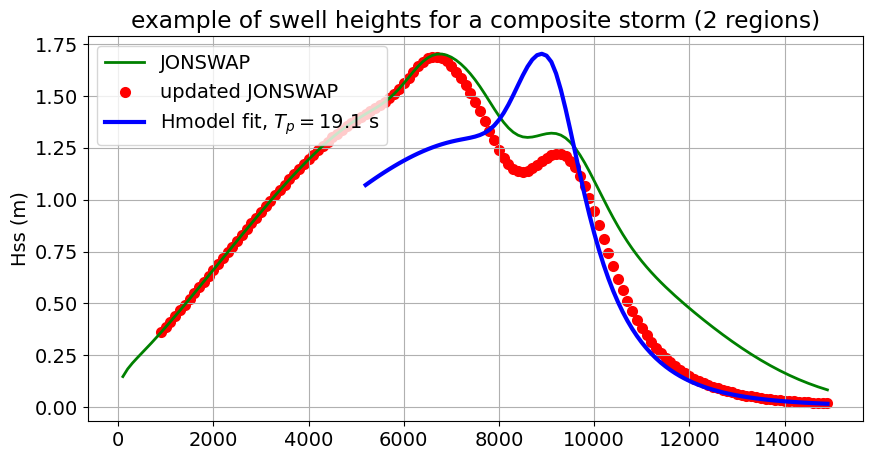

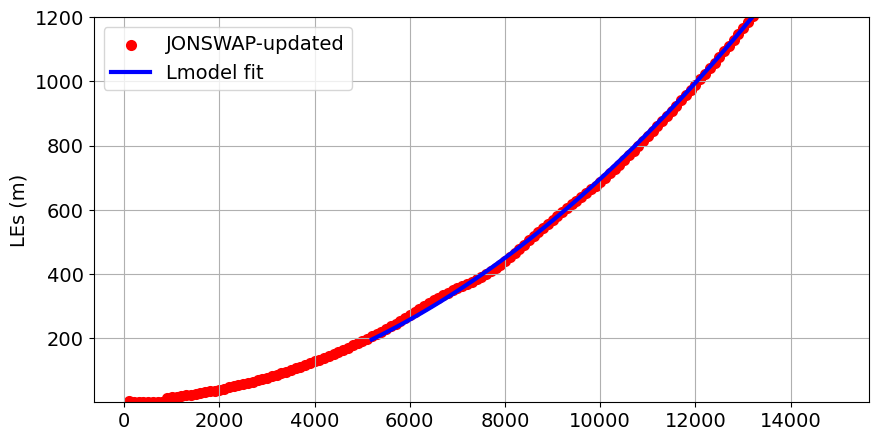

In [15]:
# fitting Hmodel as used for data ... 
R=40000/(2*np.pi)          # Earth radius

Hss=4*np.sqrt(Es)
TEs=Esm1/Es
LEs=TEs**2*9.81/(2*np.pi)

a0=(X)/R  # alpha

incognita=[0,0]
inds=np.where(LEs > 200)[0]

xopt = minimize(eval('swell.Lmodel'), incognita, args=((LEs[inds],a0[inds],'LS',tds),),\
                     method='Nelder-Mead',options={'disp': False}) 
# First we adjust the distance / time 
ashift=xopt.x[0];tshift=xopt.x[1]
fj,Lj=swell.Lmodel_eval(a0,tds,[ashift,tshift])
alp=a0+ashift

f0=0.0532;
costpow=0
gammaPM=2
r=100E3

alphaP=0.0081*9.81**2/(2*np.pi)**4
factor=4*np.sqrt(alphaP/2)/R


incognita=[0.06,2E-3,gammaPM]
xopt = minimize(eval('swell.Hmodel'), incognita, args=((Hss[inds],a0[inds],fj[inds],gammaPM,costpow,'LS'),),\
      method='Nelder-Mead',options={'disp': False})
f0=xopt.x[0]
radius=xopt.x[1]/factor

Tp=1/f0
print('Tp,R (km):',Tp,radius,'Toba H:',0.062*np.sqrt(9.81*1*Tp**3),'r*factor:',r*factor*1E-3)

HJ8=swell.Hmodel_eval(alp,fj,gammaPM,[f0,xopt.x[1],gammaPM])
#HJ8=swell.Hmodel_eval(alp,fj,gammaPM,[0.05,300000,gammaPM])

fig,axs=plt.subplots(1,1,figsize=(10,5))
axs.plot(X,4*np.sqrt(EsJ),c='g',alpha=1,linewidth=2,label='JONSWAP');
axs.scatter(X,Hss,c='r',alpha=1,linewidth=2,label='updated JONSWAP');
axs.plot(X[inds],HJ8[inds],c='b',alpha=1,linewidth=3,label='Hmodel fit, $T_p=$'+f'{1/f0:03.1f}'+' s');
#axs.plot(X,400*a0**-9,c='k',alpha=0.5,linewidth=1,label='power law');
axs.legend(loc='upper left', fontsize=14)
#axs.set_ylim(1E-2,3.5)
axs.set_ylabel('Hss (m)')
axs.set_title('example of swell heights for a composite storm (2 regions)')
fig.savefig('dispersion_model_example_restricted_fit.pdf')

fig,axs=plt.subplots(1,1,figsize=(10,5))
axs.scatter(X,LEs,c='r',alpha=1,linewidth=2,label='JONSWAP-updated');
axs.plot(X[inds],Lj[inds],c='b',alpha=1,linewidth=3,label='Lmodel fit');
#axs.plot(X,EsJm1/EsJ,c='black',alpha=1,linewidth=2,label='JONSWAP');
#axs.plot(X,15*a0,c='g',alpha=0.5,linewidth=1,label='power law');
axs.set_ylim(1E-2,1200)
axs.set_ylabel('LEs (m)')
axs.legend(loc='upper left', fontsize=14)

